In [1]:
import torch
torch.cuda.empty_cache()
torch.manual_seed(42)

In [2]:
# mode = "ebae"
mode = "ebae-ebar"

In [3]:
model_name = 'Qwen/Qwen2.5-0.5B-Instruct'
# model_name = "meta-llama/Llama-3.2-1B"

In [4]:
import pickle

if mode == "ebae":
    # read chunks using pickle
    with open("wiki_chunks_list_900.pkl", "rb") as f:
        chunks = pickle.load(f)

elif mode == "ebae-ebar":
    with open("wiki_chunks_list_ebae_ebar.pkl", "rb") as f:
        chunks = pickle.load(f)

    with open("wiki_next_sentences_list_ebae_ebar.pkl", "rb") as f:
        next_sentences = pickle.load(f)
else:
    raise ValueError("Invalid mode")

Train the model only with train data on a step-basis. In the paper, they performed 10k steps. Using Qwen 0.5B, the training using approx. 5.5k chunks occupies 22.7GB GPU, with batch_size of 4 and gradient accumulation steps of 8.

In [5]:
from train_ebae import train_steps

model_name = 'Qwen/Qwen2.5-0.5B-Instruct'

train_steps(
    model_name=model_name,
    chunks=chunks,
    next_sentences=next_sentences,
    seq_length=1024,
    batch_size=4,
    learning_rate=1e-6,
    epochs=3
)


/home/leon/tesis/spanish-legal-ir/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: Qwen/Qwen2.5-0.5B-Instruct
Tokenizing chunks with EBAE prompts and eos token...
Epoch 1/3
Effective Step: 1, Averaged Loss: 9.074258208274841
Effective Step: 2, Averaged Loss: 6.984605371952057
Effective Step: 3, Averaged Loss: 6.820354640483856
Effective Step: 4, Averaged Loss: 6.605343580245972
Effective Step: 5, Averaged Loss: 6.370923340320587
Effective Step: 6, Averaged Loss: 6.209018647670746
Effective Step: 7, Averaged Loss: 6.337730705738068
Effective Step: 8, Averaged Loss: 6.1252776980400085
Effective Step: 9, Averaged Loss: 5.706455051898956
Effective Step: 10, Averaged Loss: 5.589846432209015
Effective Step: 11, Averaged Loss: 5.718905687332153
Effective Step: 12, Averaged Loss: 5.569788634777069
Effective Step: 13, Averaged Loss: 5.208417177200317
Effective Step: 14, Averaged Loss: 5.7077972292900085
Effective Step: 15, Averaged Loss: 5.741825997829437
Effective Step: 16, Averaged Loss: 5.583305716514587
Effective Step: 17, Averaged Loss: 5.612015545368195
Effective

{0: [9.074258208274841, 6.984605371952057, 6.820354640483856, 6.605343580245972, 6.370923340320587, 6.209018647670746, 6.337730705738068, 6.1252776980400085, 5.706455051898956, 5.589846432209015, 5.718905687332153, 5.569788634777069, 5.208417177200317, 5.7077972292900085, 5.741825997829437, 5.583305716514587, 5.612015545368195, 5.642836093902588, 5.475978910923004, 5.433856189250946, 5.415271699428558, 5.350136458873749, 5.446239352226257, 5.3743696212768555, 5.41161435842514, 5.541549861431122, 5.046688556671143, 5.181333601474762, 4.973932564258575, 5.13117653131485, 5.056022644042969, 4.94245707988739, 4.905531585216522, 5.158354759216309, 5.414320468902588, 4.729110419750214, 4.4251269698143005, 4.743887841701508, 4.724220037460327, 4.335347384214401, 4.720021963119507, 4.572705447673798, 4.489868015050888, 4.740679502487183, 4.522029161453247, 4.276280432939529, 4.041342169046402, 4.094541400671005, 4.203373581171036, 4.112515509128571, 4.1738258600234985, 4.475304543972015, 4.118

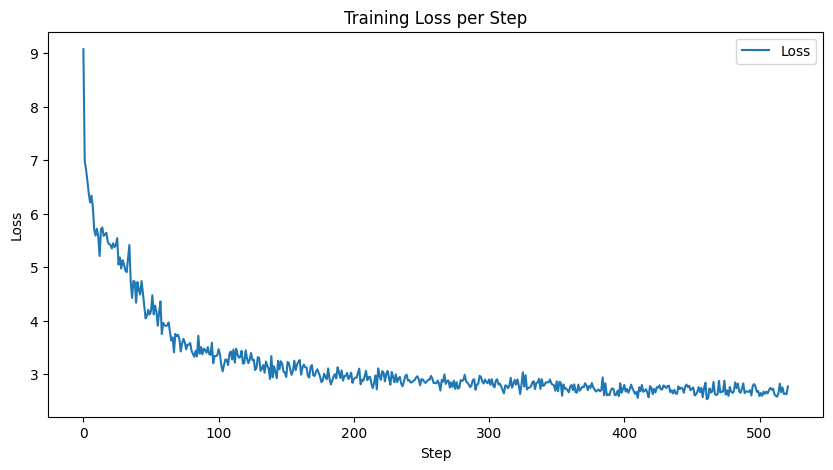

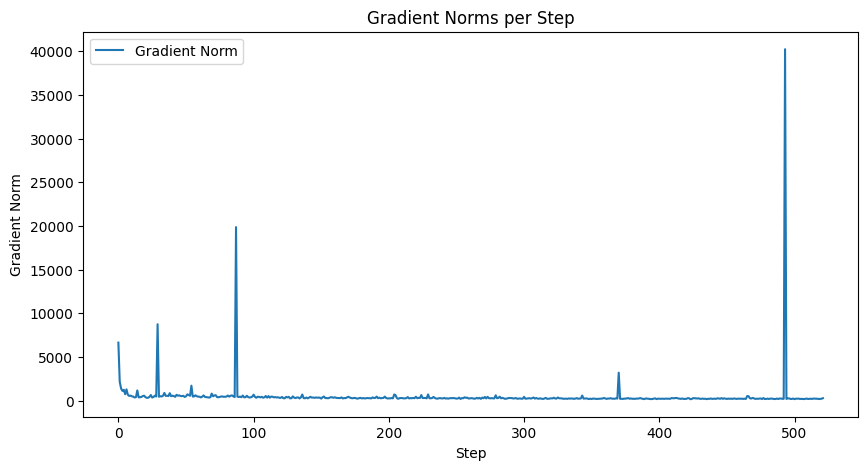

In [ ]:
import matplotlib.pyplot as plt
import torch

# Load saved data
data = torch.load("training_metrics.pth")
losses_dict = data["losses"]
gradient_norms_dict = data["gradient_norms"]

losses = []
for epoch, loss_list in losses_dict.items():
    losses.extend(loss_list)

gradient_norms = []
for epoch, gradient_norm_list in gradient_norms_dict.items():
    gradient_norms.extend(gradient_norm_list)

# Move gradient norms to CPU if they are GPU tensors
gradient_norms = [g.cpu().item() if isinstance(g, torch.Tensor) else g for g in gradient_norms]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss per Step')
plt.legend()
plt.show()

# Plot Gradient Norms
plt.figure(figsize=(10, 5))
plt.plot(gradient_norms, label='Gradient Norm')
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms per Step')
plt.legend()
plt.show()


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from huggingface_hub import HfApi, HfFolder, Repository

# Replace these with your paths and model name
model_path = "./ebar-ebae-model"
model_name = "leon-hecht/Qwen-2.5-0.5B-Instruct-spanish-ir"

# Push the model to the Hugging Face Hub
from transformers import AutoModelForCausalLM

# Load model
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Push the model and tokenizer
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)


/home/leon/tesis/spanish-legal-ir/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
model.safetensors: 100%|██████████| 1.98G/1.98G [03:07<00:00, 10.5MB/s]
tokenizer.json: 100%|██████████| 11.4M/11.4M [00:01<00:00, 10.2MB/s]


CommitInfo(commit_url='https://huggingface.co/leon-hecht/Qwen-2.5-0.5B-Instruct-spanish-ir/commit/1c0c204b553f304774193820e4ca685f018a1495', commit_message='Upload tokenizer', commit_description='', oid='1c0c204b553f304774193820e4ca685f018a1495', pr_url=None, repo_url=RepoUrl('https://huggingface.co/leon-hecht/Qwen-2.5-0.5B-Instruct-spanish-ir', endpoint='https://huggingface.co', repo_type='model', repo_id='leon-hecht/Qwen-2.5-0.5B-Instruct-spanish-ir'), pr_revision=None, pr_num=None)